# Today's Question

## Why we do not use CNN for tabular data ?
As with CNNs you have the assumption that pixels near each other are related. That might not be the case in an arbitrary table. This is a spatial inductive bias. CNNs also have translational equivariance, which isn't necessary for a table.

In [102]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## First we need to read the data to explore it

In [103]:
dataset_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
dataset_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [104]:
dataset_df.shape

(8693, 14)

In [105]:
dataset_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [106]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<Axes: xlabel='Transported'>

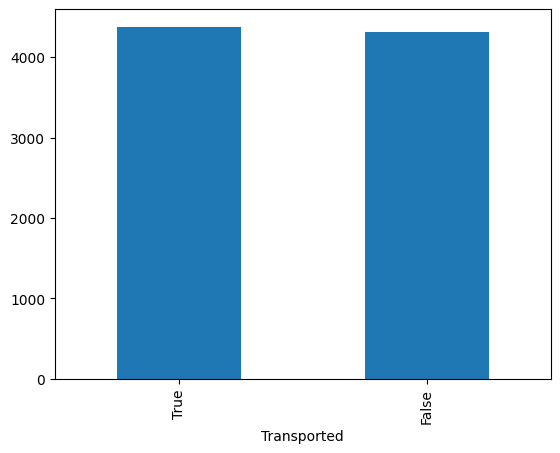

In [107]:
plot_df = dataset_df.Transported.value_counts()
plot_df.plot(kind="bar")

### Conclusion from the graph
*from the above transported bar graph we deduce that the data is equally distributed*


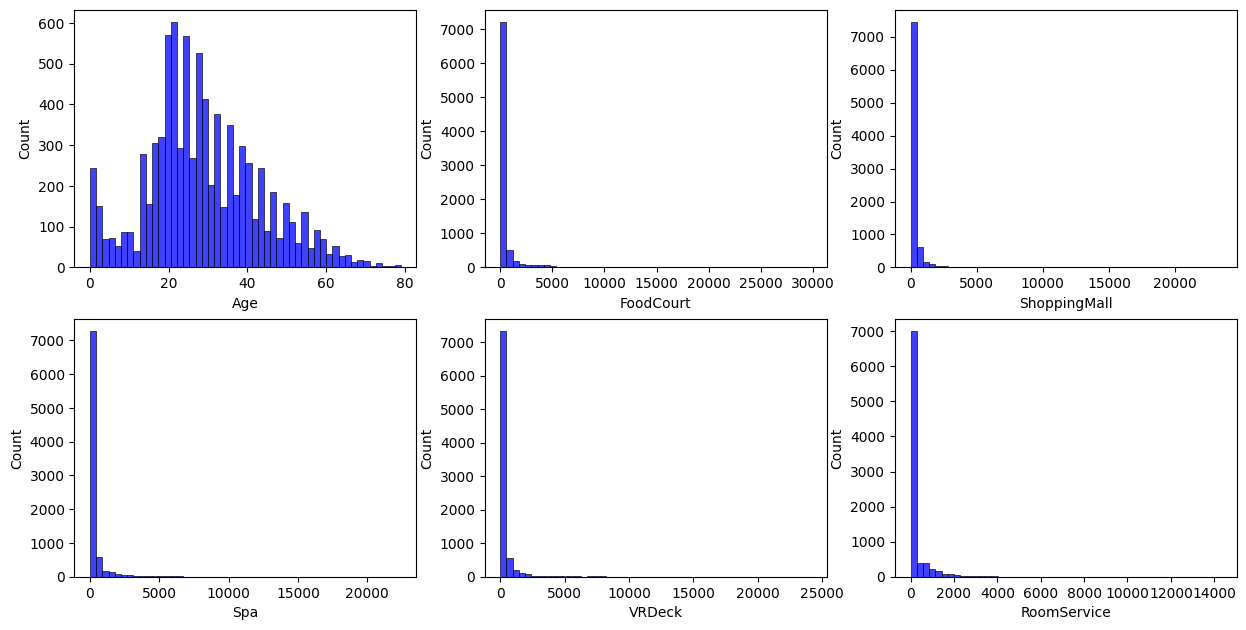

In [108]:
fig, ax = plt.subplots(2, 3, figsize=(15, 3))
plt.subplots_adjust(top=2)

sns.histplot(dataset_df['Age'], color='b', bins=50, ax=ax[0, 0])
sns.histplot(dataset_df['FoodCourt'], color='b', bins=50, ax=ax[0, 1])
sns.histplot(dataset_df['ShoppingMall'], color='b', bins=50, ax=ax[0, 2])
sns.histplot(dataset_df['Spa'], color='b', bins=50, ax=ax[1, 0])
sns.histplot(dataset_df['VRDeck'], color='b', bins=50, ax=ax[1, 1])
sns.histplot(dataset_df['RoomService'], color='b', bins=50, ax=ax[1, 2])

plt.show()

### getting a quick look at the graphs
we conclude the following:
* age is distributed just fine
* FoodCourt, Spa, ShoppingMall and VPDeck have abnormal distribution

# Dividing the data
As givien from the data we can spilit both PassengerId and Cabin to more meaningfull data

### PassengerID
Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group, so we can spilit it into:
* Group_ID
* Person_ID

### Cabin
The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard., so we can spilit it into:
* Deck
* No_Room
* Cabin

In [109]:
def update_df(df,status):
    df[['Group_ID','Person_ID']] = df['PassengerId'].str.split('_',expand=True)
    df[['Deck','No_Room','Side']] = df['Cabin'].str.split('/',expand=True)
    df.drop(['PassengerId','Name','Cabin'],axis=1,inplace=True)
    if status == 'train':
        df = df[[*df.columns[11:], *df.columns[:11]]]
    elif status == 'test':
        df = df[[*df.columns[10:], *df.columns[:10]]]
    return df
dataset_df = update_df(dataset_df,'train')

In [110]:
dataset_df.head()

,Group_ID,Person_ID,Deck,No_Room,Side,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001,01,B,0,P,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002,01,F,0,S,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003,01,A,0,S,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003,02,A,0,S,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004,01,F,1,S,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [111]:
dataset_df.shape

(8693, 16)

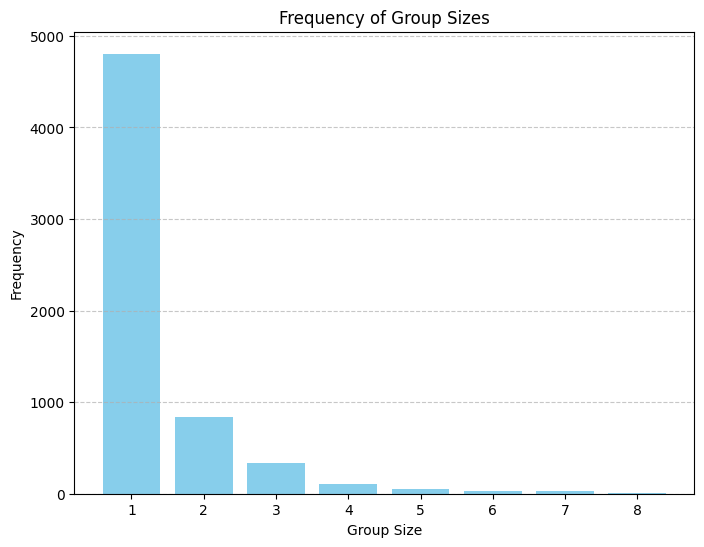

In [112]:
# Calculate group sizes
group_size = dataset_df['Group_ID'].value_counts().to_frame('count').reset_index()

# Count the occurrences of each group size
count_of_counts = group_size['count'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
plt.bar(count_of_counts.index, count_of_counts.values, color='skyblue')
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.title('Frequency of Group Sizes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We deduce from each group size that most of the passangers travelled alone.

### Check for missing values

In [113]:
dataset_df.isnull().sum()

Group_ID          0
Person_ID         0
Deck            199
No_Room         199
Side            199
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

*as we see all the features contains missings*

In [114]:
dataset_df['HomePlanet'].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [115]:
dataset_df['CryoSleep'].value_counts()

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

In [116]:
dataset_df = dataset_df.drop(['Person_ID'],axis=1)

In [117]:
dataset_df = dataset_df.drop(['No_Room'],axis=1)

since, random forest handle categorical and numircal misses (nulls) we will not preproccess it
Note:
* we will assign any numircal value other than age to zero as it makes sense
* we will assign boolean values to false or 0 

In [118]:
dataset_df.columns

Index(['Group_ID', 'Deck', 'Side', 'HomePlanet', 'CryoSleep', 'Destination',
       'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Transported'],
      dtype='object')

In [119]:
dataset_df[['RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck']] = dataset_df[['RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
dataset_df.isnull().sum()

Group_ID          0
Deck            199
Side            199
HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

In [120]:
dataset_df[['VIP', 'CryoSleep']] = dataset_df[['VIP', 'CryoSleep']].fillna(value=0)
dataset_df.isnull().sum()

Group_ID          0
Deck            199
Side            199
HomePlanet      201
CryoSleep         0
Destination     182
Age             179
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

In [121]:
avgAge = dataset_df.describe().loc['mean'].Age
dataset_df[['Age']] = dataset_df[['Age']].fillna(value=avgAge)

In [122]:
dataset_df["Transported"] = dataset_df["Transported"].astype(int)
dataset_df["Transported"].dtype

dtype('int64')

In [123]:
dataset_df.VIP = dataset_df["VIP"].astype(int)
dataset_df.CryoSleep = dataset_df["CryoSleep"].astype(int)

In [124]:
dataset_df.head()

,Group_ID,Deck,Side,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001,B,P,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,0002,F,S,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,0003,A,S,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,0003,A,S,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,0004,F,S,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1


In [125]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Group_ID      8693 non-null   object 
 1   Deck          8494 non-null   object 
 2   Side          8494 non-null   object 
 3   HomePlanet    8492 non-null   object 
 4   CryoSleep     8693 non-null   int64  
 5   Destination   8511 non-null   object 
 6   Age           8693 non-null   float64
 7   VIP           8693 non-null   int64  
 8   RoomService   8693 non-null   float64
 9   FoodCourt     8693 non-null   float64
 10  ShoppingMall  8693 non-null   float64
 11  Spa           8693 non-null   float64
 12  VRDeck        8693 non-null   float64
 13  Transported   8693 non-null   int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 950.9+ KB


In [126]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset_df, test_size=0.2, random_state=42)

In [127]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label="Transported")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label="Transported")

In [128]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [129]:
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=["accuracy"])

Use /tmp/tmprti1xdz9 as temporary training directory


In [130]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.399606. Found 6954 examples.
Training model...


[INFO 24-04-22 16:19:34.7342 UTC kernel.cc:1233] Loading model from path /tmp/tmprti1xdz9/model/ with prefix a6d590009ff84909


Model trained in 0:00:03.546643
Compiling model...


[INFO 24-04-22 16:19:35.8487 UTC decision_forest.cc:660] Model loaded with 300 root(s), 234078 node(s), and 13 input feature(s).
[INFO 24-04-22 16:19:35.8488 UTC abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-04-22 16:19:35.8488 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


## Visualize random part of tree
random forest models has 300 number of trees by default

In [131]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=50, max_depth=3)

# Evaluation 

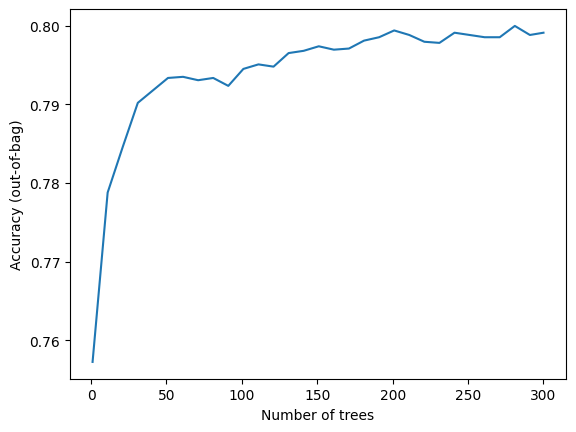

In [132]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

In [133]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=6954, accuracy=0.7991084268047167, loss=0.6355536706544869, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [134]:
evaluation = rf.evaluate(x= test_ds, return_dict=True)
evaluation

2/2 [==============================] - 0s 57ms/step - loss: 0.0000e+00 - accuracy: 0.7901


{'loss': 0.0, 'accuracy': 0.7901092767715454}

*Here we see that we reached an accuarcy of 79% which is not bad*

# Submission

In [135]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df.PassengerId
test_df = update_df(test_df,'test')

# Replace NaN values with zero
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Creating New Features - Deck, Cabin_num and Side from the column Cabin and remove Cabin

avgAge = dataset_df.describe().loc['mean'].Age
dataset_df[['Age']] = dataset_df[['Age']].fillna(value=avgAge)
# Convert boolean to 1's and 0's
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

test_df = test_df.drop(['No_Room'],axis=1)
test_df = test_df.drop(['Person_ID'],axis=1)

test_df

,Group_ID,Deck,Side,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013,G,S,Earth,1,TRAPPIST-1e,27.0,0,0.0,0.0,0.0,0.0,0.0
1,0018,F,S,Earth,0,TRAPPIST-1e,19.0,0,0.0,9.0,0.0,2823.0,0.0
2,0019,C,S,Europa,1,55 Cancri e,31.0,0,0.0,0.0,0.0,0.0,0.0
3,0021,C,S,Europa,0,TRAPPIST-1e,38.0,0,0.0,6652.0,0.0,181.0,585.0
4,0023,F,S,Earth,0,TRAPPIST-1e,20.0,0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266,G,S,Earth,1,TRAPPIST-1e,34.0,0,0.0,0.0,0.0,0.0,0.0
4273,9269,NaN,NaN,Earth,0,TRAPPIST-1e,42.0,0,0.0,847.0,17.0,10.0,144.0
4274,9271,D,P,Mars,1,55 Cancri e,NaN,0,0.0,0.0,0.0,0.0,0.0
4275,9273,D,P,Europa,0,NaN,NaN,0,0.0,2680.0,0.0,0.0,523.0


In [136]:
# Convert pd dataframe to tf dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Get the predictions for testdata
predictions = rf.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

5/5 [==============================] - 0s 58ms/step


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [137]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
